# Import

In [1]:
import mmdet
import mmcv
import mmengine
from mmengine import Config
from mmengine.runner import set_random_seed
from mmengine.runner import Runner
from mmdet.apis import init_detector, inference_detector
from mmengine.visualization import Visualizer
from mmcv.transforms import Compose

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from fastcore.all import *
import matplotlib.pyplot as plt
import json

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.

from sklearn.model_selection import KFold, StratifiedKFold
from pytorch_lightning import seed_everything

import cv2
import base64
from pycocotools import _mask as coco_mask
import typing as t
import zlib

import torch
import gc

# Config

In [3]:
class CFG:
    class general:
        #project_name = "HuBMAP2023"
        input_path = "../data/input"
        output_path = "../data/output"
        save_name = "debug"
        seed = 0
        cv = True
        #wandb_desabled = True
        n_splits = 5
        fold = [0] # list (0-idx start) or null. Set one element list, hold-out mode.

# Utils

In [4]:
# from https://github.com/ZFTurbo/Weighted-Boxes-Fusion
"""
MIT License

Copyright (c) 2020 ZFTurbo (Roman Solovyev)

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

# coding: utf-8
__author__ = 'ZFTurbo: https://kaggle.com/zfturbo'

import numpy as np
from numba import jit


def prepare_boxes(boxes, scores, labels, masks):
    result_boxes = boxes.copy()

    cond = (result_boxes < 0)
    cond_sum = cond.astype(np.int32).sum()
    if cond_sum > 0:
        print('Warning. Fixed {} boxes coordinates < 0'.format(cond_sum))
        result_boxes[cond] = 0

    cond = (result_boxes > 1)
    cond_sum = cond.astype(np.int32).sum()
    if cond_sum > 0:
        print('Warning. Fixed {} boxes coordinates > 1. Check that your boxes was normalized at [0, 1]'.format(cond_sum))
        result_boxes[cond] = 1

    boxes1 = result_boxes.copy()
    result_boxes[:, 0] = np.min(boxes1[:, [0, 2]], axis=1)
    result_boxes[:, 2] = np.max(boxes1[:, [0, 2]], axis=1)
    result_boxes[:, 1] = np.min(boxes1[:, [1, 3]], axis=1)
    result_boxes[:, 3] = np.max(boxes1[:, [1, 3]], axis=1)

    area = (result_boxes[:, 2] - result_boxes[:, 0]) * (result_boxes[:, 3] - result_boxes[:, 1])
    cond = (area == 0)
    cond_sum = cond.astype(np.int32).sum()
    if cond_sum > 0:
        print('Warning. Removed {} boxes with zero area!'.format(cond_sum))
        result_boxes = result_boxes[area > 0]
        scores = scores[area > 0]
        labels = labels[area > 0]
        masks = masks[area > 0]

    return result_boxes, scores, labels, masks


def cpu_soft_nms_float(dets, sc, Nt, sigma, thresh, method):
    """
    Based on: https://github.com/DocF/Soft-NMS/blob/master/soft_nms.py
    It's different from original soft-NMS because we have float coordinates on range [0; 1]

    :param dets:   boxes format [x1, y1, x2, y2]
    :param sc:     scores for boxes
    :param Nt:     required iou 
    :param sigma:  
    :param thresh: 
    :param method: 1 - linear soft-NMS, 2 - gaussian soft-NMS, 3 - standard NMS
    :return: index of boxes to keep
    """

    # indexes concatenate boxes with the last column
    N = dets.shape[0]
    indexes = np.array([np.arange(N)])
    dets = np.concatenate((dets, indexes.T), axis=1)

    # the order of boxes coordinate is [y1, x1, y2, x2]
    y1 = dets[:, 1]
    x1 = dets[:, 0]
    y2 = dets[:, 3]
    x2 = dets[:, 2]
    scores = sc
    areas = (x2 - x1) * (y2 - y1)

    for i in range(N):
        # intermediate parameters for later parameters exchange
        tBD = dets[i, :].copy()
        tscore = scores[i].copy()
        tarea = areas[i].copy()
        pos = i + 1

        #
        if i != N - 1:
            maxscore = np.max(scores[pos:], axis=0)
            maxpos = np.argmax(scores[pos:], axis=0)
        else:
            maxscore = scores[-1]
            maxpos = 0
        if tscore < maxscore:
            dets[i, :] = dets[maxpos + i + 1, :]
            dets[maxpos + i + 1, :] = tBD
            tBD = dets[i, :]

            scores[i] = scores[maxpos + i + 1]
            scores[maxpos + i + 1] = tscore
            tscore = scores[i]

            areas[i] = areas[maxpos + i + 1]
            areas[maxpos + i + 1] = tarea
            tarea = areas[i]

        # IoU calculate
        xx1 = np.maximum(dets[i, 1], dets[pos:, 1])
        yy1 = np.maximum(dets[i, 0], dets[pos:, 0])
        xx2 = np.minimum(dets[i, 3], dets[pos:, 3])
        yy2 = np.minimum(dets[i, 2], dets[pos:, 2])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[pos:] - inter)

        # Three methods: 1.linear 2.gaussian 3.original NMS
        if method == 1:  # linear
            weight = np.ones(ovr.shape)
            weight[ovr > Nt] = weight[ovr > Nt] - ovr[ovr > Nt]
        elif method == 2:  # gaussian
            weight = np.exp(-(ovr * ovr) / sigma)
        else:  # original NMS
            weight = np.ones(ovr.shape)
            weight[ovr > Nt] = 0

        scores[pos:] = weight * scores[pos:]

    # select the boxes and keep the corresponding indexes
    inds = dets[:, 4][scores > thresh]
    keep = inds.astype(int)
    return keep


@jit(nopython=True)
def nms_float_fast(dets, scores, thresh):
    """
    # It's different from original nms because we have float coordinates on range [0; 1]
    :param dets: numpy array of boxes with shape: (N, 5). Order: x1, y1, x2, y2, score. All variables in range [0; 1]
    :param thresh: IoU value for boxes
    :return: index of boxes to keep
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep


def nms_method(boxes, scores, labels, masks, method=3, iou_thr=0.5, sigma=0.5, thresh=0.001, weights=None):
    """
    :param boxes: list of boxes predictions from each model, each box is 4 numbers. 
    It has 3 dimensions (models_number, model_preds, 4)
    Order of boxes: x1, y1, x2, y2. We expect float normalized coordinates [0; 1] 
    :param scores: list of scores for each model 
    :param labels: list of labels for each model
    :param method: 1 - linear soft-NMS, 2 - gaussian soft-NMS, 3 - standard NMS
    :param iou_thr: IoU value for boxes to be a match 
    :param sigma: Sigma value for SoftNMS
    :param thresh: threshold for boxes to keep (important for SoftNMS)
    :param weights: list of weights for each model. Default: None, which means weight == 1 for each model

    :return: boxes: boxes coordinates (Order of boxes: x1, y1, x2, y2). 
    :return: scores: confidence scores
    :return: labels: boxes labels
    """

    # If weights are specified
    if weights is not None:
        if len(boxes) != len(weights):
            print('Incorrect number of weights: {}. Must be: {}. Skip it'.format(len(weights), len(boxes)))
        else:
            weights = np.array(weights)
            for i in range(len(weights)):
                scores[i] = (np.array(scores[i]) * weights[i]) / weights.sum()

    # We concatenate everything
    boxes = np.concatenate(boxes)
    scores = np.concatenate(scores)
    labels = np.concatenate(labels)
    masks = np.concatenate(masks)

    # Fix coordinates and removed zero area boxes
    boxes, scores, labels, masks = prepare_boxes(boxes, scores, labels, masks)

    # Run NMS independently for each label
    unique_labels = np.unique(labels)
    final_boxes = []
    final_scores = []
    final_labels = []
    final_masks = []
    for l in unique_labels:
        condition = (labels == l)
        boxes_by_label = boxes[condition]
        scores_by_label = scores[condition]
        labels_by_label = np.array([l] * len(boxes_by_label))
        masks_by_label = masks[condition]

        if method != 3:
            keep = cpu_soft_nms_float(boxes_by_label.copy(), scores_by_label.copy(), Nt=iou_thr, sigma=sigma, thresh=thresh, method=method)
        else:
            # Use faster function
            keep = nms_float_fast(boxes_by_label, scores_by_label, thresh=iou_thr)

        final_boxes.append(boxes_by_label[keep])
        final_scores.append(scores_by_label[keep])
        final_labels.append(labels_by_label[keep])
        final_masks.append(masks_by_label[keep])
    final_boxes = np.concatenate(final_boxes)
    final_scores = np.concatenate(final_scores)
    final_labels = np.concatenate(final_labels)
    final_masks = np.concatenate(final_masks)

    return final_boxes, final_scores, final_labels, final_masks


def nms(boxes, scores, labels, masks, iou_thr=0.5, weights=None):
    """
    Short call for standard NMS 
    
    :param boxes: 
    :param scores: 
    :param labels: 
    :param iou_thr: 
    :param weights: 
    :return: 
    """
    return nms_method(boxes, scores, labels, masks, method=3, iou_thr=iou_thr, weights=weights)


def soft_nms(boxes, scores, labels, masks, method=2, iou_thr=0.5, sigma=0.5, thresh=0.001, weights=None):
    """
    Short call for Soft-NMS
     
    :param boxes: 
    :param scores: 
    :param labels: 
    :param method: 
    :param iou_thr: 
    :param sigma: 
    :param thresh: 
    :param weights: 
    :return: 
    """
    return nms_method(boxes, scores, labels, masks, method=method, iou_thr=iou_thr, sigma=sigma, thresh=thresh, weights=weights)

In [5]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def nms_predictions(classes, scores, bboxes, masks, 
                    iou_th=.5, shape=(512, 512), per_image=None):
    he, wd = shape[0], shape[1]
    boxes_list = [[x[0] / wd, x[1] / he, x[2] / wd, x[3] / he]
                  for x in bboxes]
    scores_list = [x for x in scores]
    labels_list = [x for x in classes]
    masks_list = [x for x in masks]
    nms_bboxes, nms_scores, nms_classes, nms_masks = nms(
        [boxes_list], 
        [scores_list], 
        [labels_list],
        [masks_list],
        weights=None,
        iou_thr=iou_th
    )
    
    if per_image is None:
        return nms_classes, nms_scores, nms_bboxes, nms_masks
    else:
        return nms_classes[:per_image], nms_scores[:per_image], nms_bboxes[:per_image], nms_masks[:per_image]
    
def nms_predictions2(classes, scores, bboxes, masks, 
                    iou_th=.5, shape=(512, 512), per_image=None):
    he, wd = shape[0], shape[1]
    boxes_list = [x for x in bboxes]
    scores_list = [x for x in scores]
    labels_list = [x for x in classes]
    masks_list = [x for x in masks]
    nms_bboxes, nms_scores, nms_classes, nms_masks = nms(
        [boxes_list], 
        [scores_list], 
        [labels_list],
        [masks_list],
        weights=None,
        iou_thr=iou_th
    )
    
    if per_image is None:
        return nms_classes, nms_scores, nms_bboxes, nms_masks
    else:
        return nms_classes[:per_image], nms_scores[:per_image], nms_bboxes[:per_image], nms_masks[:per_image]

def get_classes_scores_masks(fn, predictor):
    im = mmcv.imread(str(fn), channel_order="rgb")
    height, width, _ = im.shape
    pred = inference_detector(predictor, im)
    
    if len(pred.pred_instances.masks) == 0:
        return [None], [None], [None], [None], height, width
    
    pred_masks = pred.pred_instances.masks.cpu().numpy()
    pred_classes = pred.pred_instances.labels.cpu().numpy().tolist()
    pred_scores = pred.pred_instances.scores.cpu().numpy().tolist()
    pred_boxes = pred.pred_instances.bboxes.cpu().numpy().tolist()
    
    return pred_classes, pred_scores, pred_masks, pred_boxes, height, width

def get_classes_scores_masks_tta(fn, predictor, TTA_SIZE):
    im = mmcv.imread(str(fn), channel_order="rgb")
    height, width, _ = im.shape
    pred_masks = []
    pred_classes = []
    pred_scores = []
    pred_boxes = []
    
    for size in TTA_SIZE:
        test_pipeline = [
            dict(type="mmdet.LoadImageFromNDArray", backend_args=None),
            dict(type="Resize", scale=(size, size), keep_ratio=True),
            dict(type="LoadAnnotations", with_bbox=True, with_mask=True),
            dict(
                type="PackDetInputs",
                meta_keys=("img_id", "img_path", "ori_shape", "img_shape", "scale_factor"))
        ]
        test_pipeline = Compose(test_pipeline)
        
        pred = inference_detector(predictor, im, test_pipeline)

        pred_masks.extend(pred.pred_instances.masks.cpu().numpy())
        pred_classes.extend(pred.pred_instances.labels.cpu().numpy().tolist())
        pred_scores.extend(pred.pred_instances.scores.cpu().numpy().tolist())
        pred_boxes.extend(pred.pred_instances.bboxes.cpu().numpy().tolist())
        
    if len(pred_masks) == 0:
        return [None], [None], [None], [None], height, width
    
    pred_classes, pred_scores, pred_boxes, pred_masks = nms_predictions(pred_classes, pred_scores, pred_boxes, pred_masks)
    
    return pred_classes, pred_scores, pred_masks, pred_boxes, height, width

In [6]:
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    # check input mask --
    if mask.dtype != bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

# Main

### Read data

In [7]:
df = pd.read_csv('/notebooks/data/input/tile_meta.csv')
#df = df[df["dataset"]==3]
df = df[df["dataset"]!=1]
df["train_image_names"] = [f"/notebooks/data/input/train/{i}.tif" for i in df["id"]]

In [8]:
train_image_names = df["train_image_names"].to_list()

In [9]:
TTA = True
TTA_SIZE = [1024, 1280, 1536]
DILATION = False
DILATION_ITER = 2

In [10]:
from mmengine import Config

In [11]:
predictors = []

"""
#cfg = Config.fromfile("/notebooks/data/output/base_all/exp132_resnet_all/cascade-mask-rcnn_r50_fpn_ms-3x_coco.py")
cfg = Config.fromfile("../mmdetection/configs/cascade_rcnn/cascade-mask-rcnn_r50_fpn_ms-3x_coco.py")
checkpoint_file = "/notebooks/data/output/base_all/exp132_resnet_all/epoch_1.pth"

# dummy
cfg.metainfo = {
    #"classes": ("glomerulus", "blood_vessel", )
    "classes": ("blood_vessel", )
}
cfg.test_pipeline = [
            dict(type="LoadImageFromFile", backend_args=None),
        dict(type="Resize", scale=(1024, 1024), keep_ratio=True),
        dict(type="LoadAnnotations", with_bbox=True, with_mask=True),
        dict(
            type="PackDetInputs",
            meta_keys=("img_id", "img_path", "ori_shape", "img_shape", "scale_factor"))
    ]
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.data_root = ""
cfg.train_dataloader.dataset.ann_file = ""
cfg.train_dataloader.dataset.data_root = cfg.data_root
#cfg.train_dataloader.dataset.data_prefix.img = "train"
cfg.train_dataloader.dataset.metainfo = cfg.metainfo
cfg.val_dataloader.dataset.ann_file = ""
cfg.val_dataloader.dataset.data_root = cfg.data_root
#cfg.val_dataloader.dataset.data_prefix.img = "train"
cfg.val_dataloader.dataset.metainfo = cfg.metainfo
cfg.test_dataloader = cfg.val_dataloader
cfg.val_evaluator.ann_file = ""
cfg.val_evaluator.metric = "segm"
cfg.test_evaluator = cfg.val_evaluator
cfg.model.roi_head.bbox_head[0].num_classes = 1
cfg.model.roi_head.bbox_head[1].num_classes = 1
cfg.model.roi_head.bbox_head[2].num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

cfg.model.test_cfg.rcnn.score_thr = 0.25
cfg.model.test_cfg.rcnn.max_per_img = 100
predictor = init_detector(cfg, checkpoint_file)
predictors.append(predictor)

#cfg = Config.fromfile("/notebooks/data/output/base_all/exp131_resnext_all/cascade-mask-rcnn_x101-64x4d_fpn_ms-3x_coco.py")
cfg = Config.fromfile("../mmdetection/configs/cascade_rcnn/cascade-mask-rcnn_x101-64x4d_fpn_ms-3x_coco.py")
checkpoint_file = "/notebooks/data/output/base_all/exp131_resnext_all/epoch_1.pth"

# dummy
cfg.metainfo = {
    #"classes": ("glomerulus", "blood_vessel", )
    "classes": ("blood_vessel", )
}
cfg.test_pipeline = [
            dict(type="LoadImageFromFile", backend_args=None),
        dict(type="Resize", scale=(1024, 1024), keep_ratio=True),
        dict(type="LoadAnnotations", with_bbox=True, with_mask=True),
        dict(
            type="PackDetInputs",
            meta_keys=("img_id", "img_path", "ori_shape", "img_shape", "scale_factor"))
    ]
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.data_root = ""
cfg.train_dataloader.dataset.ann_file = ""
cfg.train_dataloader.dataset.data_root = cfg.data_root
#cfg.train_dataloader.dataset.data_prefix.img = "train"
cfg.train_dataloader.dataset.metainfo = cfg.metainfo
cfg.val_dataloader.dataset.ann_file = ""
cfg.val_dataloader.dataset.data_root = cfg.data_root
#cfg.val_dataloader.dataset.data_prefix.img = "train"
cfg.val_dataloader.dataset.metainfo = cfg.metainfo
cfg.test_dataloader = cfg.val_dataloader
cfg.val_evaluator.ann_file = ""
cfg.val_evaluator.metric = "segm"
cfg.test_evaluator = cfg.val_evaluator
cfg.model.roi_head.bbox_head[0].num_classes = 1
cfg.model.roi_head.bbox_head[1].num_classes = 1
cfg.model.roi_head.bbox_head[2].num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

cfg.model.test_cfg.rcnn.score_thr = 0.25
cfg.model.test_cfg.rcnn.max_per_img = 100
predictor = init_detector(cfg, checkpoint_file)
predictors.append(predictor)
"""

cfg = Config.fromfile("../mmdetection/configs/convnext/cascade-mask-rcnn_convnext-t-p4-w7_fpn_4conv1fc-giou_amp-ms-crop-3x_coco.py")
checkpoint_file = "/notebooks/data/output/third_all/convnext_all_3rd_only_5000/epoch_1.pth"

# dummy
cfg.metainfo = {
    #"classes": ("glomerulus", "blood_vessel", )
    "classes": ("blood_vessel", )
}
cfg.test_pipeline = [
            dict(type="LoadImageFromFile", backend_args=None),
        dict(type="Resize", scale=(1024, 1024), keep_ratio=True),
        dict(type="LoadAnnotations", with_bbox=True, with_mask=True),
        dict(
            type="PackDetInputs",
            meta_keys=("img_id", "img_path", "ori_shape", "img_shape", "scale_factor"))
    ]
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.data_root = ""
cfg.train_dataloader.dataset.ann_file = ""
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = "train"
cfg.train_dataloader.dataset.metainfo = cfg.metainfo
cfg.val_dataloader.dataset.ann_file = ""
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = "train"
cfg.val_dataloader.dataset.metainfo = cfg.metainfo
cfg.test_dataloader = cfg.val_dataloader
cfg.val_evaluator.ann_file = ""
cfg.val_evaluator.metric = "segm"
cfg.test_evaluator = cfg.val_evaluator
cfg.model.roi_head.bbox_head[0].num_classes = 1
cfg.model.roi_head.bbox_head[1].num_classes = 1
cfg.model.roi_head.bbox_head[2].num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

cfg.model.test_cfg.rcnn.score_thr = 0.95
cfg.model.test_cfg.rcnn.max_per_img = 100
predictor = init_detector(cfg, checkpoint_file)
predictors.append(predictor)
#"""

"""
cfg = Config.fromfile("/notebooks/data/output/exp39_convnext_valid_change/cascade-mask-rcnn_convnext-t-p4-w7_fpn_4conv1fc-giou_amp-ms-crop-3x_coco.py")
checkpoint_file = "/notebooks/data/output/exp39_convnext_valid_change/epoch_1.pth"
cfg.model.test_cfg.rcnn.score_thr = 0.25
cfg.model.test_cfg.rcnn.max_per_img = 100
predictor = init_detector(cfg, checkpoint_file)
predictors.append(predictor)
"""

del predictor, cfg
torch.cuda.empty_cache()
gc.collect()

Loads checkpoint by local backend from path: /notebooks/data/output/third_all/convnext_all_3rd_only_5000/epoch_1.pth


48

In [11]:
predictors = []

"""
cfg = Config.fromfile("/notebooks/data/output/base/convnext_valid_change/cascade-mask-rcnn_convnext-t-p4-w7_fpn_4conv1fc-giou_amp-ms-crop-3x_coco.py")
checkpoint_file = "/notebooks/data/output/base/convnext_valid_change/epoch_1.pth"
cfg.model.test_cfg.rcnn.score_thr = 0.9
cfg.model.test_cfg.rcnn.max_per_img = 100
predictor = init_detector(cfg, checkpoint_file)
predictors.append(predictor)

cfg = Config.fromfile("/notebooks/data/output/base/resnet_valid_change/cascade-mask-rcnn_r50_fpn_ms-3x_coco.py")
checkpoint_file = "/notebooks/data/output/base/resnet_valid_change/epoch_1.pth"
cfg.model.test_cfg.rcnn.score_thr = 0.9
cfg.model.test_cfg.rcnn.max_per_img = 100
predictor = init_detector(cfg, checkpoint_file)
predictors.append(predictor)

cfg = Config.fromfile("/notebooks/data/output/base/resnext_valid_change/cascade-mask-rcnn_x101-64x4d_fpn_ms-3x_coco.py")
checkpoint_file = "/notebooks/data/output/base/resnext_valid_change/epoch_1.pth"
cfg.model.test_cfg.rcnn.score_thr = 0.9
cfg.model.test_cfg.rcnn.max_per_img = 100
predictor = init_detector(cfg, checkpoint_file)
predictors.append(predictor)
"""

"""
cfg = Config.fromfile("/notebooks/data/output/flip_fold/exp127_convnext_flip/cascade-mask-rcnn_convnext-t-p4-w7_fpn_4conv1fc-giou_amp-ms-crop-3x_coco.py")
checkpoint_file = "/notebooks/data/output/flip_fold/exp127_convnext_flip/epoch_1.pth"
cfg.model.test_cfg.rcnn.score_thr = 0.5
cfg.model.test_cfg.rcnn.max_per_img = 100
predictor = init_detector(cfg, checkpoint_file)
predictors.append(predictor)

cfg = Config.fromfile("/notebooks/data/output/flip_fold/exp128_resnet_flip/cascade-mask-rcnn_r50_fpn_ms-3x_coco.py")
checkpoint_file = "/notebooks/data/output/flip_fold/exp128_resnet_flip/epoch_1.pth"
cfg.model.test_cfg.rcnn.score_thr = 0.5
cfg.model.test_cfg.rcnn.max_per_img = 100
predictor = init_detector(cfg, checkpoint_file)
predictors.append(predictor)

cfg = Config.fromfile("/notebooks/data/output/flip_fold/exp129_resnext_flip/cascade-mask-rcnn_x101-64x4d_fpn_ms-3x_coco.py")
checkpoint_file = "/notebooks/data/output/flip_fold/exp129_resnext_flip/epoch_1.pth"
cfg.model.test_cfg.rcnn.score_thr = 0.5
cfg.model.test_cfg.rcnn.max_per_img = 100
predictor = init_detector(cfg, checkpoint_file)
predictors.append(predictor)
"""

#cfg = Config.fromfile("/notebooks/data/output/exp39_convnext_valid_change/cascade-mask-rcnn_convnext-t-p4-w7_fpn_4conv1fc-giou_amp-ms-crop-3x_coco.py")
#checkpoint_file = "/notebooks/data/output/exp39_convnext_valid_change/epoch_1.pth"
#cfg.model.test_cfg.rcnn.score_thr = 0.25
#cfg.model.test_cfg.rcnn.max_per_img = 100
#predictor = init_detector(cfg, checkpoint_file)
#predictors.append(predictor)

#cfg = Config.fromfile("/notebooks/data/output/base_unsure_fold/convnext_unsure_fold/cascade-mask-rcnn_convnext-t-p4-w7_fpn_4conv1fc-giou_amp-ms-crop-3x_coco.py")
#checkpoint_file = "/notebooks/data/output/base_unsure_fold/convnext_unsure_fold/epoch_1.pth"
#cfg.model.test_cfg.rcnn.score_thr = 0.5
#cfg.model.test_cfg.rcnn.max_per_img = 100
#predictor = init_detector(cfg, checkpoint_file)
#predictors.append(predictor)

#cfg = Config.fromfile("/notebooks/data/output/base_unsure_fold/resnet_unsure_fold/cascade-mask-rcnn_r50_fpn_ms-3x_coco.py")
#checkpoint_file = "/notebooks/data/output/base_unsure_fold/resnet_unsure_fold/epoch_1.pth"
#cfg.model.test_cfg.rcnn.score_thr = 0.5
#cfg.model.test_cfg.rcnn.max_per_img = 100
#predictor = init_detector(cfg, checkpoint_file)
#predictors.append(predictor)

#cfg = Config.fromfile("/notebooks/data/output/third_all/convnext_all_3rd_only_5000/cascade-mask-rcnn_convnext-t-p4-w7_fpn_4conv1fc-giou_amp-ms-crop-3x_coco.py")
#checkpoint_file = "/notebooks/data/output/third_all/convnext_all_3rd_only_5000/epoch_1.pth"
#cfg.model.test_cfg.rcnn.score_thr = 0.95
#cfg.model.test_cfg.rcnn.max_per_img = 100
#predictor = init_detector(cfg, checkpoint_file)
#predictors.append(predictor)

del predictor, cfg
torch.cuda.empty_cache()
gc.collect()

Loads checkpoint by local backend from path: /notebooks/data/output/third_all/convnext_all_3rd_only_5000/epoch_1.pth


AttributeError: 'NoneType' object has no attribute 'dataset'

### Predict

In [12]:
for fn in tqdm(train_image_names):
    file_name = fn.split("/")[-1].split(".")[0]

    classes_list = []
    scores_list = []
    masks_list = []
    bboxes_list = []
    for predictor in predictors:
        if TTA:
            classes, scores, masks, bboxes, height, width = get_classes_scores_masks_tta(fn, predictor, TTA_SIZE)
        else:
            classes, scores, masks, bboxes, height, width = get_classes_scores_masks(fn, predictor)
        if classes[0] is None:
            continue
            
        masks_list.extend(masks)
        classes_list.extend(classes)
        scores_list.extend(scores)
        bboxes_list.extend(bboxes)
    
    if len(classes_list) == 0:
        classes, scores, bboxes, masks = [None], [None], [None], [None]
    else:
        classes, scores, bboxes, masks = nms_predictions2(classes_list, scores_list, bboxes_list, masks_list)

    mask_list = []
    for i, (class_, score, mask) in enumerate(zip(classes, scores, masks)):
        if class_ is None:
            continue
        #if int(class_) != 1:
        #    continue
            
        if DILATION:
            mask = np.array(mask, dtype=np.uint8)
            mask = cv2.dilate(mask, np.ones((3, 3), dtype=np.uint8), iterations=2)
            mask = np.array(mask, dtype=bool)
            
        mask_list.append(mask)
        
    mask_list = np.array(mask_list)
    np.savez_compressed(f"/pseudo/{file_name}_pseudo", mask_list)

  0%|          | 0/6611 [00:00<?, ?it/s]

3


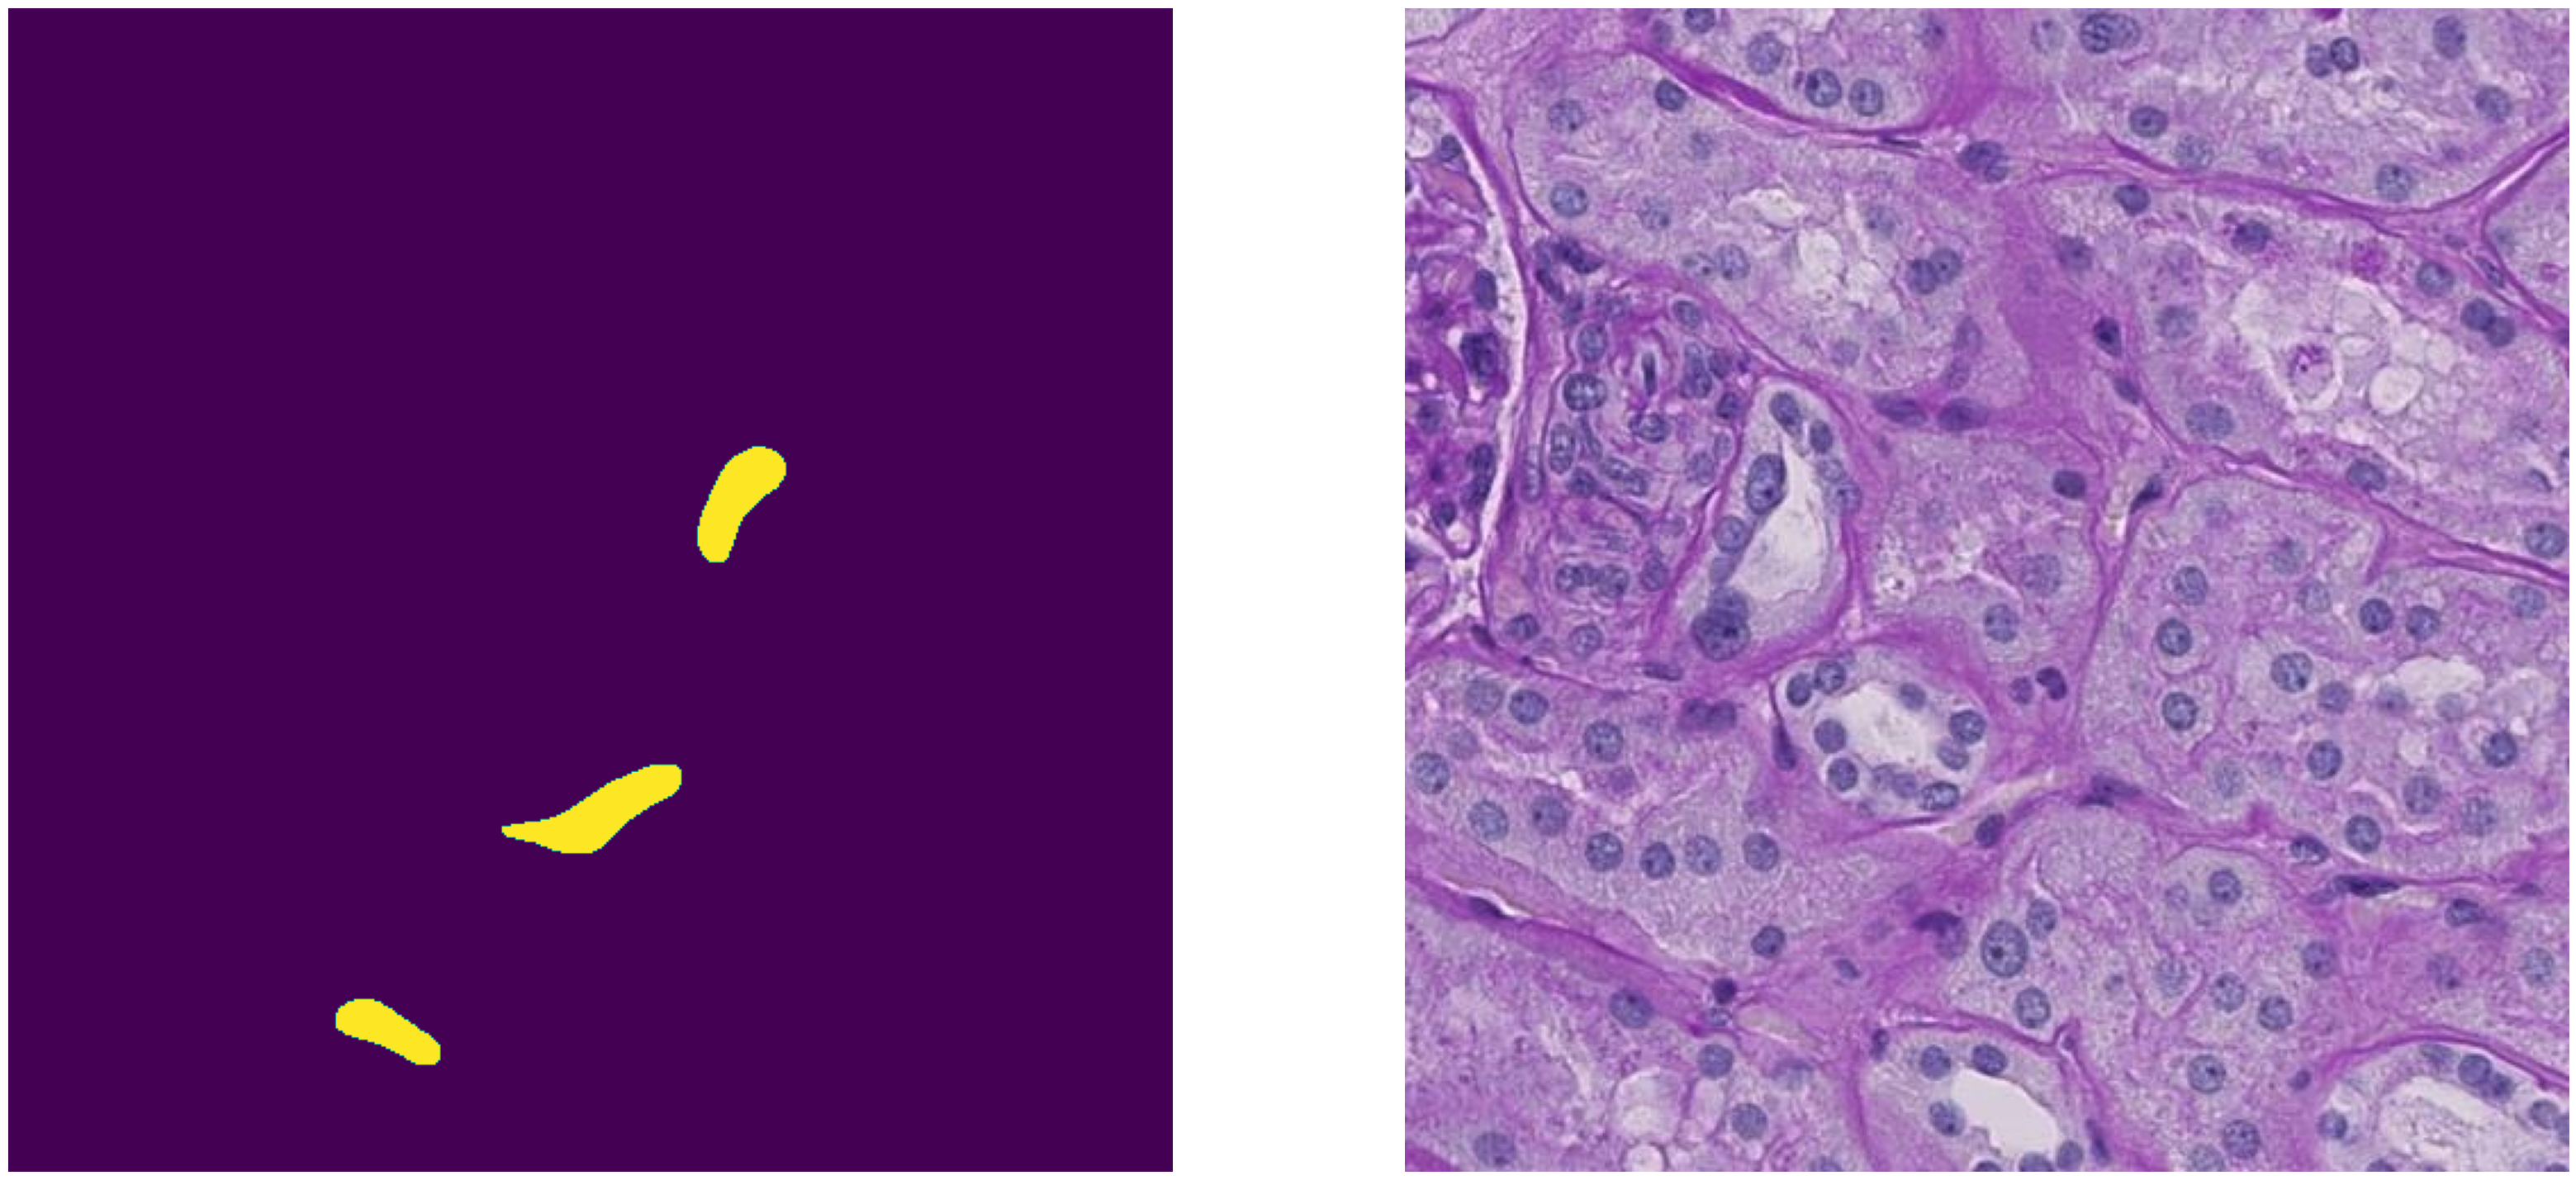

In [13]:
classes_list = []
scores_list = []
masks_list = []
bboxes_list = []
for predictor in predictors:
    if TTA:
        classes, scores, masks, bboxes, height, width = get_classes_scores_masks_tta(train_image_names[80], predictor, TTA_SIZE)
    else:
        classes, scores, masks, bboxes, height, width = get_classes_scores_masks(train_image_names[80], predictor)
    if classes[0] is None:
        continue

    masks_list.extend(masks)
    classes_list.extend(classes)
    scores_list.extend(scores)
    bboxes_list.extend(bboxes)

if len(classes_list) == 0:
    classes, scores, bboxes, masks = [None], [None], [None], [None]
else:
    classes, scores, bboxes, masks = nms_predictions2(classes_list, scores_list, bboxes_list, masks_list)

print(len(masks))
if masks[0] is not None:
    _, axs = plt.subplots(1,2, figsize=(40,30))
    axs[1].imshow(cv2.imread(str(train_image_names[80])))
    axs[1].axis("off")
    mask = np.zeros((512, 512))
    for (class_, score_, mask_) in zip(classes, scores, masks):
        #if int(class_) != 1:
        #    continue
            
        #if score_ < 0.5:
        #    continue
            
        if DILATION:
            mask_ = np.array(mask_, dtype=np.uint8)
            mask_ = cv2.dilate(mask_, np.ones((3, 3), dtype=np.uint8), iterations=DILATION_ITER)
            mask_ = np.array(mask_, dtype=bool)
        
        mask += np.array(mask_, dtype="int")

    mask = mask.clip(0,1)
    axs[0].imshow(mask)
    axs[0].axis("off")

In [14]:
npz = np.load(f"/pseudo/{file_name}_pseudo.npz")
npz["arr_0"]

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal